# Lambda Iterations

In [1]:
import os
import sys
import matplotlib.pyplot as plt

magritteFolder = '/home/atulits/atulit/MasterThesis/Magritte/'

sys.path.append(magritteFolder)

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

In [2]:
dimension = 1
npoints   = 100
nrays     = 200
nspecs    = 5
nlspecs   = 1
nquads    = 15

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-6   # [.]
temp   = 20.0     # [K]
turb   = 150.00   # [.]


def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol  * nH2(r)


rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


modelFile = 'vanZadelhoff_1a_1D.hdf5'
lamdaFile = f'{magritteFolder}tests/data/test.txt'


model = magritte.Model ()
model.parameters.set_spherical_symmetry(True)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set([[r, 0, 0] for r in rs])
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_rays_spherical_symmetry (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

/home/atulits/atulit/MasterThesis/Magritte/src/io/python/io_python_hdf5.py:83: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with hp.File (io_file) as file:
/home/atulits/atulit/MasterThesis/Magritte/src/io/python/io_python_hdf5.py:132: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with hp.File (io_file) as file:


0

In [3]:
def max_relative_difference(a, b):
    return np.max(2.0 * np.abs((a - b) / (a + b)))

In [4]:
def Anderson_acc_gen(x , num_it, l):
    unit = np.ones(num_it-1)
    #Column vectors for U matrix but here we have row matrix
    U_transpose = []
    for i in range(0,num_it-1):
            U_transpose.append((x[i] - x[i+1]))
    U_transpose = np.array(U_transpose)       
    
    #multiply two matrix
    M = np.matmul(U_transpose, U_transpose.T, dtype = np.float32)
    
    # l is regularisation coefficient 
    M = M + l*np.identity(len(M))
    
    # inverse of U and U_T
    M = np.linalg.inv(M)
    # Normalizaton factor
    Norm = np.matmul(M,unit, dtype = np.float32)
    Norm = np.matmul(unit,Norm, dtype = np.float32)
    #coeeficients c's
    c = np.matmul(M,unit, dtype = np.float32)
    c = c/Norm
    print(sum(c))
    #np.save("c_"+str(m)+"_"+str(l))
    S_acc = 0
    for p in range(0,num_it-1):
        S_acc = S_acc + (c[p]*x[p+1])  
    return (S_acc,c)
    

In [5]:
Nmax = 100
iteration = []
it_diff = []
pops = []
pop  = np.copy(model.lines.lineProducingSpecies[0].population)
pops.append(pop)

#order of Anderson acc and regularization coefficient
m = 2
l = 100
Coefficients = []
#no. of itertates
num_iterates = (m+2)

for it in range(Nmax):
    iteration.append(it)
    # Compute radiation field and resulting populations
    model.compute_radiation_field()
    model.compute_Jeff()

    if it%(m+2) == 0 and it != 0 and it>=12 :     
        A = []
        k = it - num_iterates
        for p in range(0,num_iterates):
            A.append(pops[k+p])
        temp = Anderson_acc_gen(A, num_iterates , l)
        pop  =  temp[0]
        Coefficients.append(temp[1])
        model.lines.lineProducingSpecies[0].population = pop 
        model.lines.set_emissivity_and_opacity()
    else:
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)
    max_diff = max_relative_difference(pops[-1], pops[-2])
    it_diff.append(max_diff)
    # Check for convergence
    if (max_diff < 1.0e-6):
        break
    print('After', it, 'iteration(s), max_diff =', max_diff)

After 0 iteration(s), max_diff = 0.6906639565036251066
After 1 iteration(s), max_diff = 1.386898356240952229
After 2 iteration(s), max_diff = 1.5194578337927477554
After 3 iteration(s), max_diff = 1.442008136682642982
After 4 iteration(s), max_diff = 1.3159452949010593761
After 5 iteration(s), max_diff = 1.1936211155038236554
After 6 iteration(s), max_diff = 1.0779506534533851136
After 7 iteration(s), max_diff = 0.9458272499352951235
After 8 iteration(s), max_diff = 0.79514234178698010906
After 9 iteration(s), max_diff = 0.6240763059491291871
After 10 iteration(s), max_diff = 0.44949164770386421932
After 11 iteration(s), max_diff = 0.29509281147720698178
0.9999999701976776
After 12 iteration(s), max_diff = 0.78717451717853651925
After 13 iteration(s), max_diff = 0.4832586991130363464
After 14 iteration(s), max_diff = 0.31534731866096288425
After 15 iteration(s), max_diff = 0.18966444058697053414
1.0
After 16 iteration(s), max_diff = 0.5951125520814424422
After 17 iteration(s), max_diff

In [6]:
np.save(str(m)+'_order_'+str(l), it_diff )
np.save("C_"+str(m)+'order_'+str(l), Coefficients )

[[0.26471716 0.35022667 0.38505614]
 [0.3331636  0.33345023 0.33338618]
 [0.33321056 0.33341673 0.33337274]
 [0.33329308 0.33336037 0.33334658]
 [0.33331996 0.33334222 0.33333784]
 [0.33332878 0.33333632 0.33333492]
 [0.33333173 0.3333344  0.3333339 ]
 [0.33333278 0.33333367 0.3333335 ]
 [0.3333331  0.3333335  0.3333334 ]
 [0.33333328 0.33333337 0.33333337]
 [0.3333333  0.33333334 0.33333334]
 [0.33333334 0.33333334 0.3333333 ]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.3333333 ]
 [0.33333334 0.33333334 0.33333334]
 [0.3333333  0.33333334 0.3333333 ]
 [0.33333334 0.3333333  0.3333333 ]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.3333333  0.3333333 ]
 [0.33333334 0.3333333  0.3333333 ]]


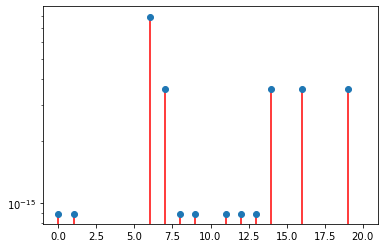

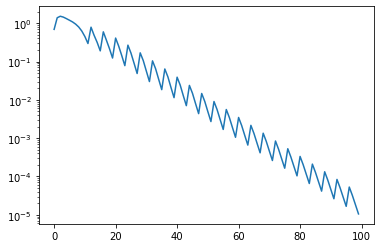